In [11]:
import json
import re
import sys
from pathlib import Path
from iohblade.loggers import ExperimentLogger
from llamea.ast_features import extract_ast_features
from iohblade.loggers import ExperimentLogger
from iohblade.plots import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json


In [12]:
logger = ExperimentLogger('/home/neocortex/repos/BLADE/results/MABBOB_guided', True)
logger.add_read_dir('/home/neocortex/repos/BLADE/results/MABBOB_guided_baselines')
logger.add_read_dir('/home/neocortex/repos/BLADE/results/MABBOB_guided_baselines2')
log_data = logger.get_data()
log_data.head()

,method_name,problem_name,llm_name,method,problem,llm,solution,log_dir,seed
0,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '1075fb19-2d1a-4413-9005-a84684f12f29',...",run-ES-MA_BBOB-2,2
1,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '97b09f41-16dd-4b97-b046-9dcd1f56a34c',...",run-ES-MA_BBOB-1,1
2,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '008715f8-d903-40a3-b331-ffbbeff335d1',...",run-ES-MA_BBOB-5,5
3,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '2a2b9226-c20f-44ac-95be-b81a5536bba3',...",run-ES-MA_BBOB-3,3
4,ES,MA_BBOB,gpt-5-mini-2025-08-07,"{'method_name': 'ES', 'budget': 200, 'kwargs':...","{'name': 'MA_BBOB', 'dims': [10], 'training_in...","{'model': 'gpt-5-mini-2025-08-07', 'code_patte...","{'id': '79bbe510-8d01-4e86-bb38-258c33bcbd1d',...",run-ES-MA_BBOB-4,4


In [13]:
methods, problems = logger.get_methods_problems()
print(methods)
print(problems)

['ES-guided (gemini)', 'MCTS_AHD', 'LHNS:vns', 'ES', 'ES-guided', 'ES (gemini)']
['MA_BBOB']


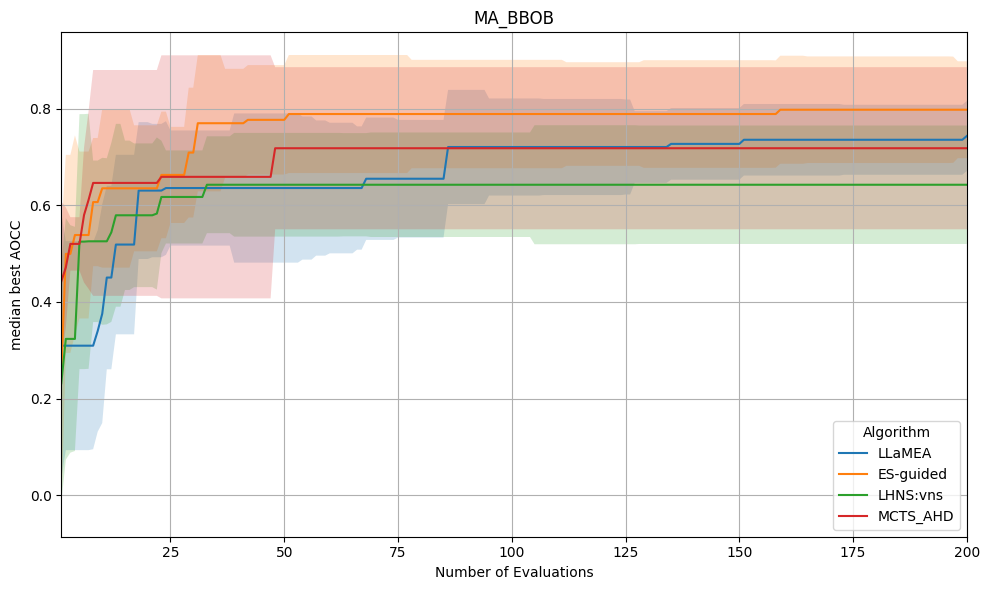

In [14]:
fig = plot_convergence(logger, metric="AOCC", methods=["ES", "ES-guided", "LHNS:vns","MCTS_AHD"], save=False, return_fig=True, budget=200, separate_lines=False)
ax = fig.axes[0]   # or however you're getting your axis
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
plt.show()

In [15]:
data = logger.get_problem_data("MA_BBOB")

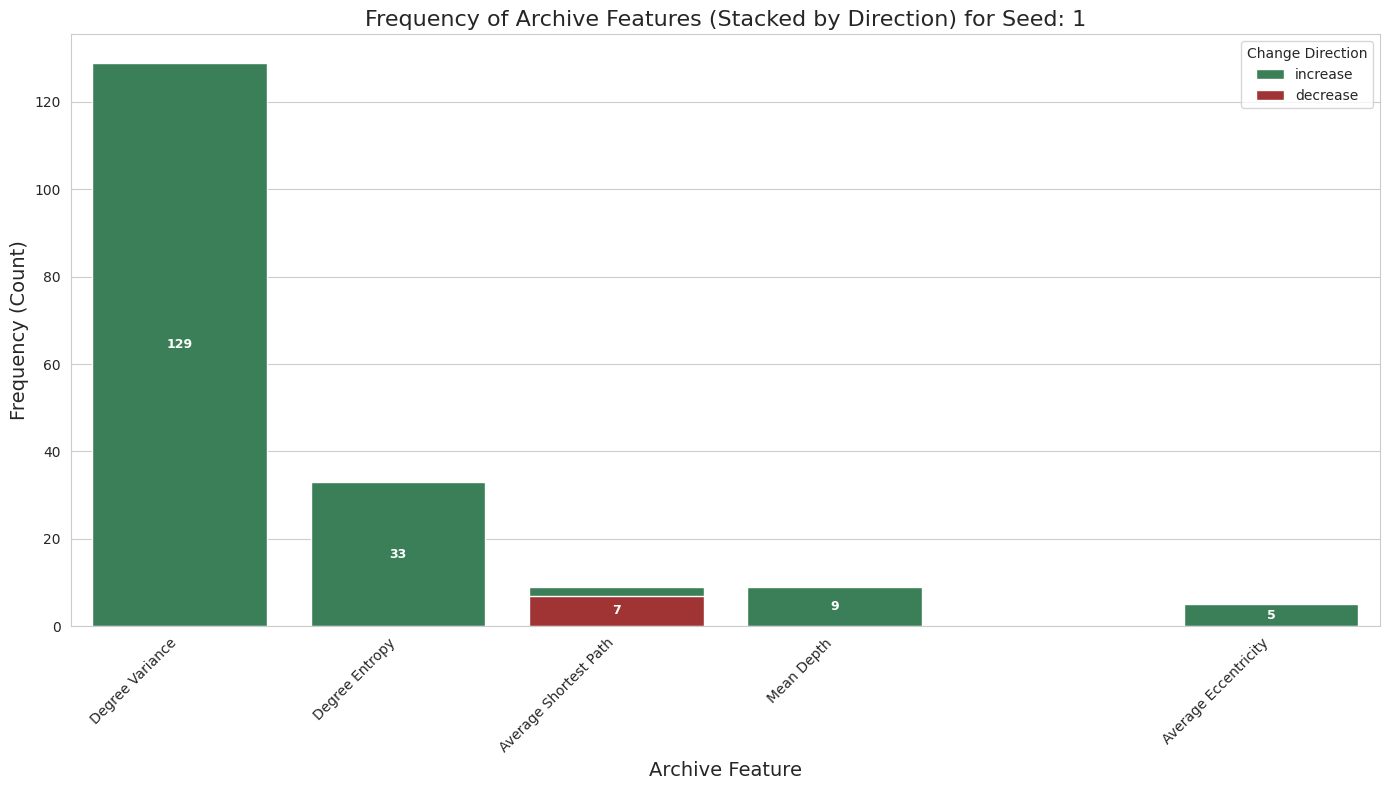

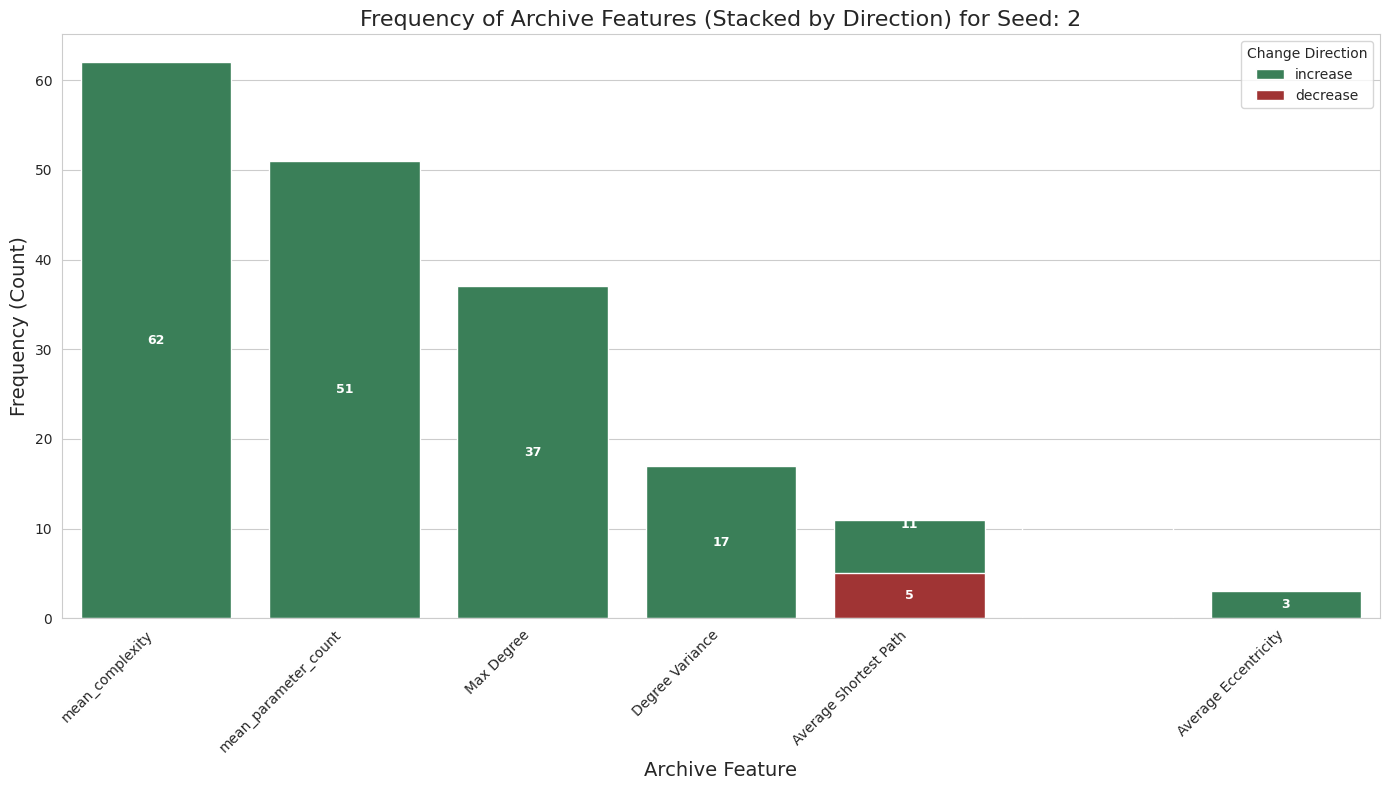

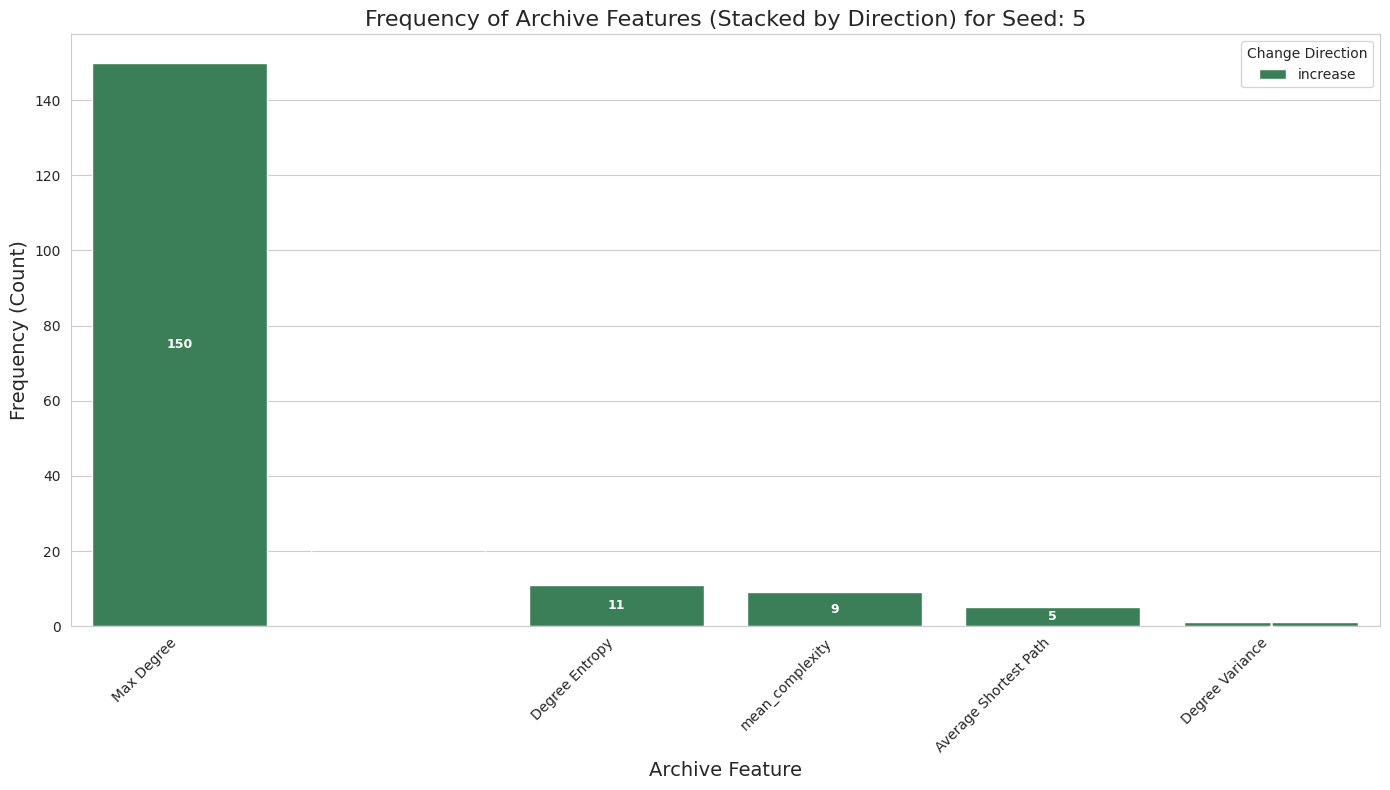

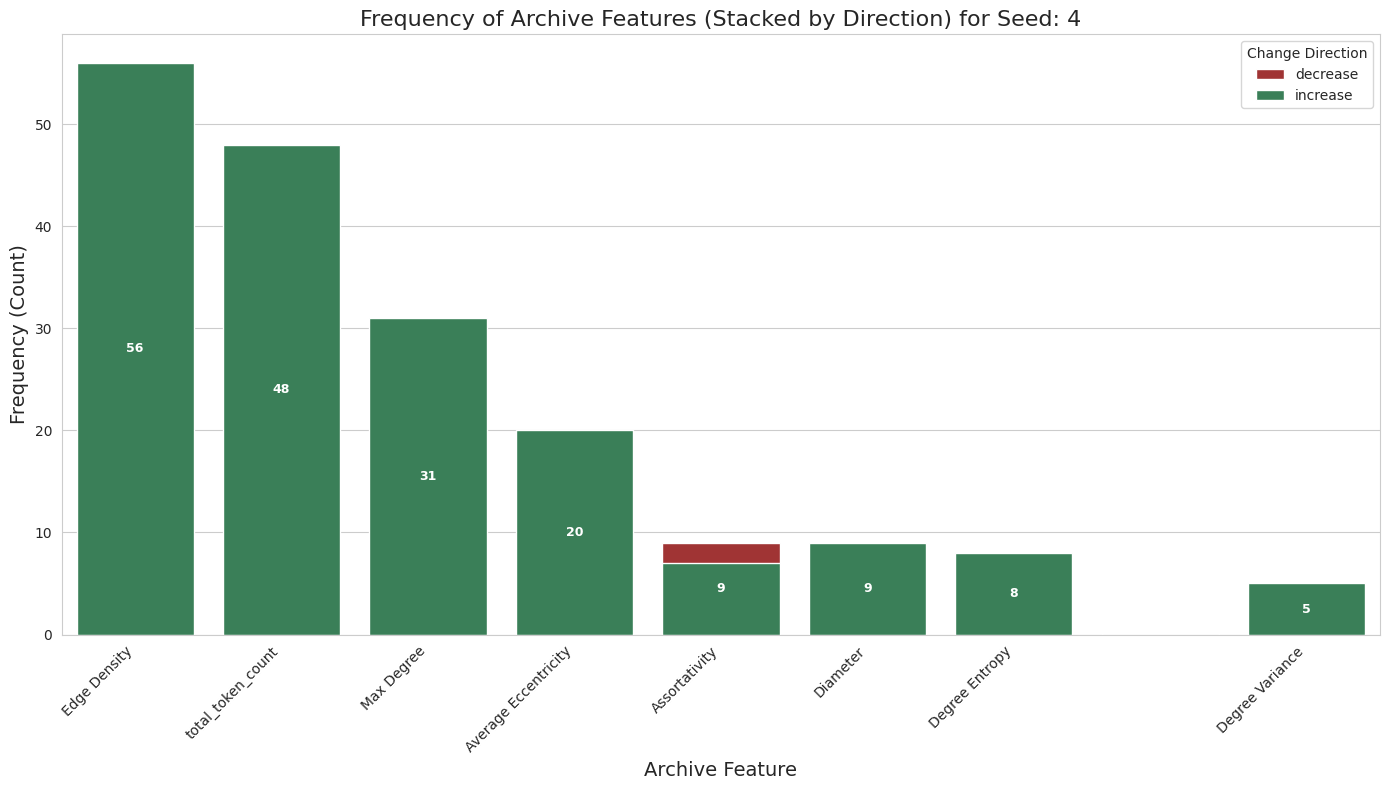

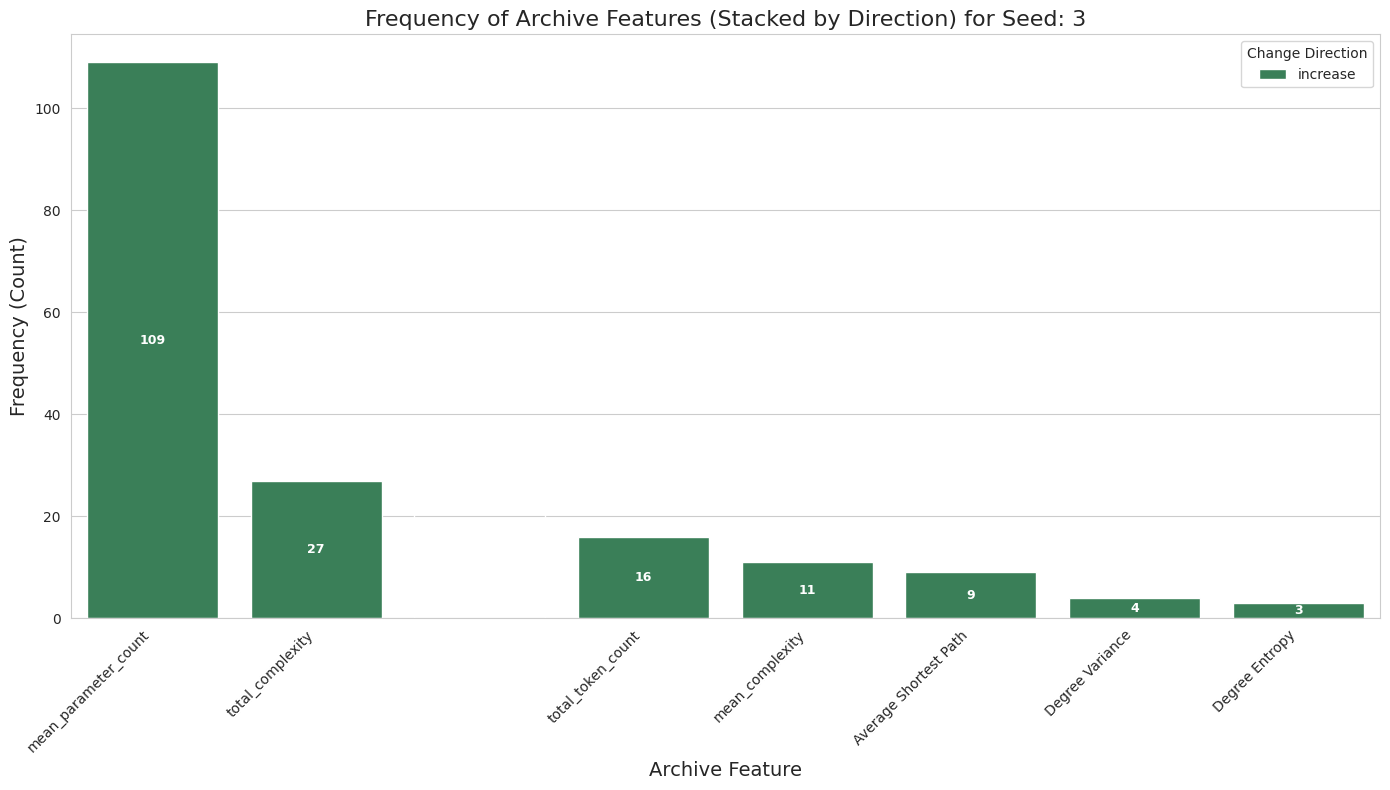

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# generate histogram of archive_feature per seed
def plot_archive_feature_histograms(df):
    """
    Generates and saves a histogram of 'archive_feature' counts for each unique 'seed'.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'seed' and 'archive_feature' columns.
    """
    if 'seed' not in df.columns or 'archive_feature' not in df.columns:
        print("Error: DataFrame must contain 'seed' and 'archive_feature' columns.")
        return

    # Get all unique seeds
    unique_seeds = df['seed'].unique()

    # Set up plotting style
    sns.set_style("whitegrid")

    for seed in unique_seeds:
        # Filter data for the current seed
        df_seed = df[df['seed'] == seed]

        # Calculate the feature counts for the current seed
        feature_counts = df_seed['archive_feature'].value_counts().reset_index()
        feature_counts.columns = ['archive_feature', 'count']

        # Skip plotting if no features exist for this seed (shouldn't happen with the filtering, but good practice)
        if feature_counts.empty:
            print(f"No data for seed: {seed}")
            continue

        # Create the figure and axes
        plt.figure(figsize=(12, 7))

        # Create the bar plot using seaborn
        sns.barplot(
            data=feature_counts,
            x='archive_feature',
            y='count',
            palette="viridis",
            hue="archive_feature",
            legend=False,
            order=feature_counts['archive_feature'] # Use the sorted order from value_counts
        )

        # Set labels and title
        plt.title(f'Frequency of Archive Features for Seed: {seed}', fontsize=16)
        plt.xlabel('Archive Feature', fontsize=14)
        plt.ylabel('Frequency (Count)', fontsize=14)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right', fontsize=10)

        # Add counts on top of bars
        for index, row in feature_counts.iterrows():
            plt.text(index, row['count'] + 0.1, str(row['count']), color='black', ha="center")

        # Adjust layout to prevent labels from being cut off
        plt.tight_layout()

        # Save the figure
        file_name = f'archive_feature_histogram_seed_{seed}.png'
        plt.savefig(file_name)
        plt.show()
        plt.close() # Close the plot to free memory

def plot_archive_feature_stacked_histograms(df, name="guided"):
    """
    Generates and saves a stacked bar chart of 'archive_feature' counts for each unique 'seed', 
    where the bars are segmented by 'archive_direction'.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'seed', 'archive_feature', 
                           and 'archive_direction' columns.
    """
    required_cols = ['seed', 'archive_feature', 'archive_direction']
    if not all(col in df.columns for col in required_cols):
        print(f"Error: DataFrame must contain {required_cols} columns.")
        return

    # Get all unique seeds
    unique_seeds = df['seed'].unique()

    # Set up plotting style
    sns.set_style("whitegrid")

    for seed in unique_seeds:
        # Filter data for the current seed
        df_seed = df[df['seed'] == seed]

        # --- Key Change: Prepare data for stacking ---
        # Calculate the feature counts, grouped by both archive_feature and archive_direction
        # This will create a count for each unique combination (e.g., Feature A + Increase, Feature A + Decrease)
        feature_counts_stacked = (
            df_seed.groupby(['archive_feature', 'archive_direction'])
                   .size()
                   .reset_index(name='count')
        )

        # Skip plotting if no features exist for this seed
        if feature_counts_stacked.empty:
            print(f"No data for seed: {seed}")
            continue

        # --- Plotting ---

        # Create the figure and axes
        plt.figure(figsize=(14, 8))

        # Create the stacked bar plot using seaborn
        # By setting x='archive_feature' and hue='archive_direction',
        # seaborn's barplot automatically handles the grouping and stacking
        # of the 'count' data when the data is prepared correctly (as above).
        
        sns.barplot(
            data=feature_counts_stacked,
            x='archive_feature',
            y='count',
            hue='archive_direction', # **New Hue parameter for stacking**
            palette={"increase": "seagreen", "decrease": "firebrick"}, # Set specific colors
            dodge=False, # **Set dodge=False for stacking** (True is for grouped bars)
            # Use the order from value_counts for the total height, if desired, 
            # though this is less critical for stacked bars
            order=df_seed['archive_feature'].value_counts().index 
        )

        # Set labels and title
        plt.title(f'Frequency of Archive Features (Stacked by Direction) for Seed: {seed}', fontsize=16)
        plt.xlabel('Archive Feature', fontsize=14)
        plt.ylabel('Frequency (Count)', fontsize=14)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right', fontsize=10)

        # Add legend for the directions
        plt.legend(title='Change Direction')

        # --- Adding Annotations for Stacked Bars (Optional but helpful) ---
        # This is more complex for stacked bars, but essential to show component counts.
        # We need the total count per feature for the y-position of the annotation.
        total_counts = df_seed['archive_feature'].value_counts()
        
        # Iterate over the original unique features for positioning
        for i, feature in enumerate(total_counts.index):
            # Get data for the specific feature
            feature_data = feature_counts_stacked[feature_counts_stacked['archive_feature'] == feature]
            
            # Calculate running height for annotation placement
            current_height = 0
            
            for _, row in feature_data.iterrows():
                # Place the component count in the middle of its stack segment
                annotation_y = current_height + (row['count'] / 2)
                
                # Plot the count for the segment
                plt.text(i, annotation_y, str(row['count']), 
                         color='white', ha="center", va="center", fontweight='bold', fontsize=9)
                
                # Update the height for the next segment
                current_height += row['count']

        # Adjust layout to prevent labels from being cut off
        plt.tight_layout()

        # Save the figure
        file_name = f'archive_feature_stacked_histogram_{name}_{seed}.png'
        plt.savefig(file_name)
        plt.show()
        plt.close() # Close the plot to free memory

        #print(f"Generated plot: {file_name}")
plot_archive_feature_stacked_histograms(data[data['method_name'] == "ES-guided"], "ES-guided")


/tmp/ipykernel_2266408/3487314429.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['consistency'] = df.apply(check_direction_consistency, axis=1)


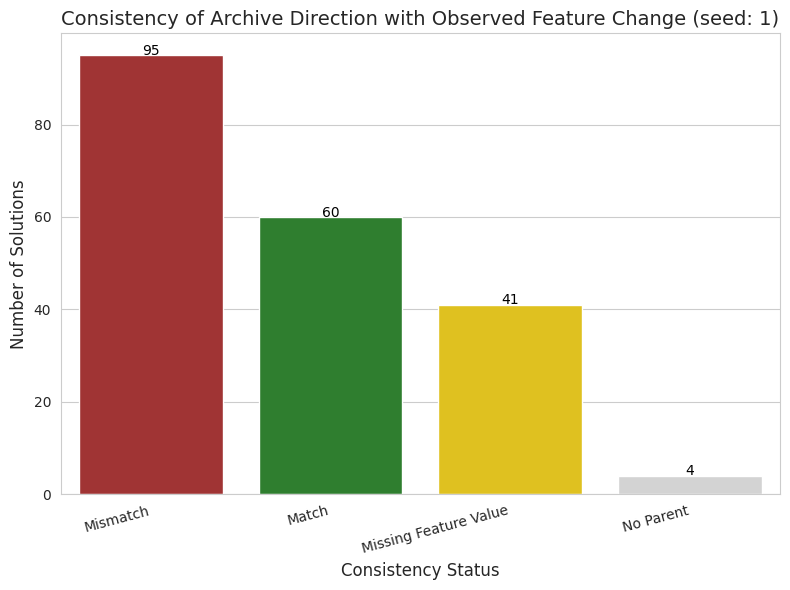

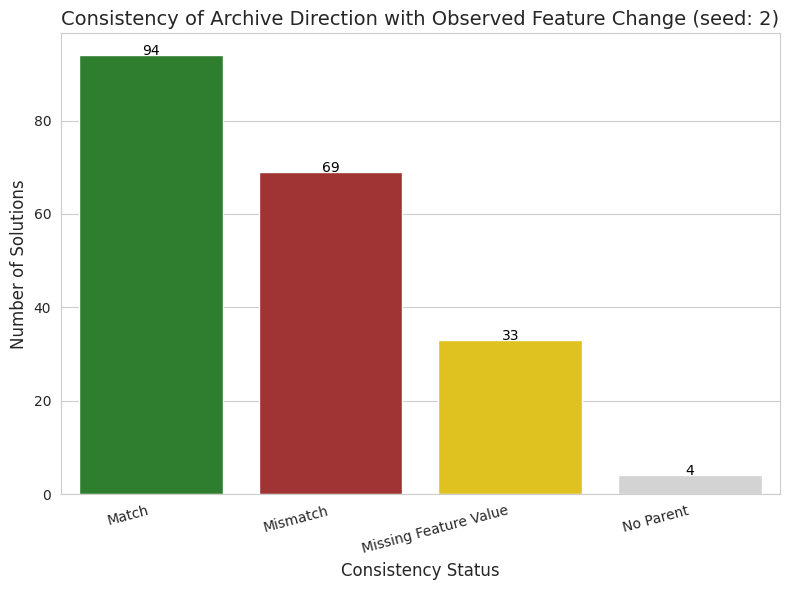

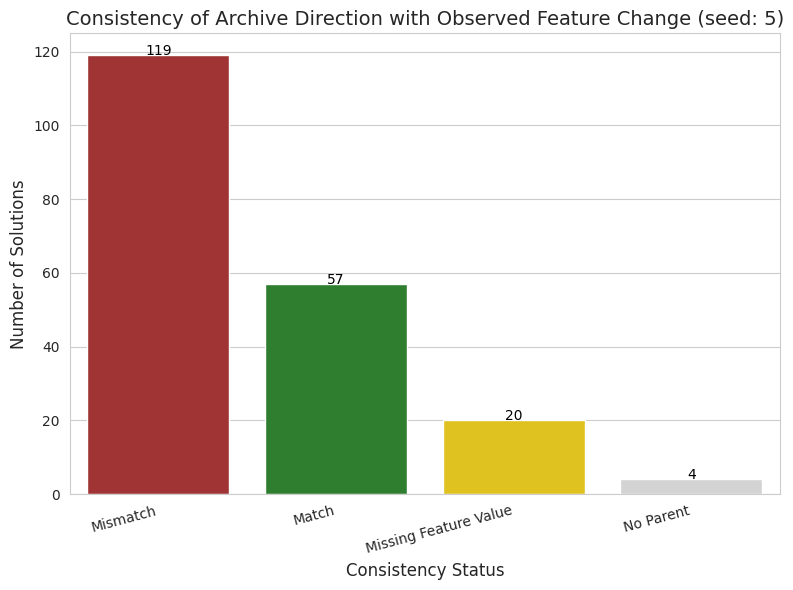

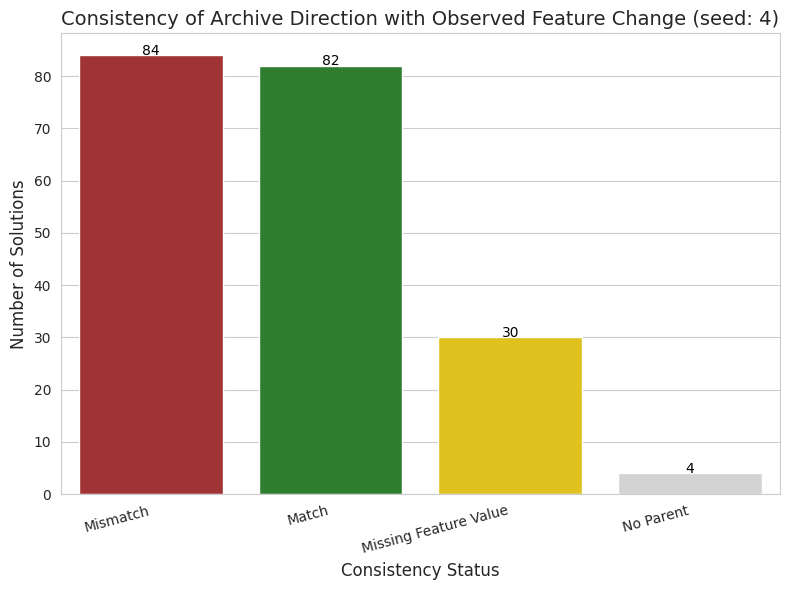

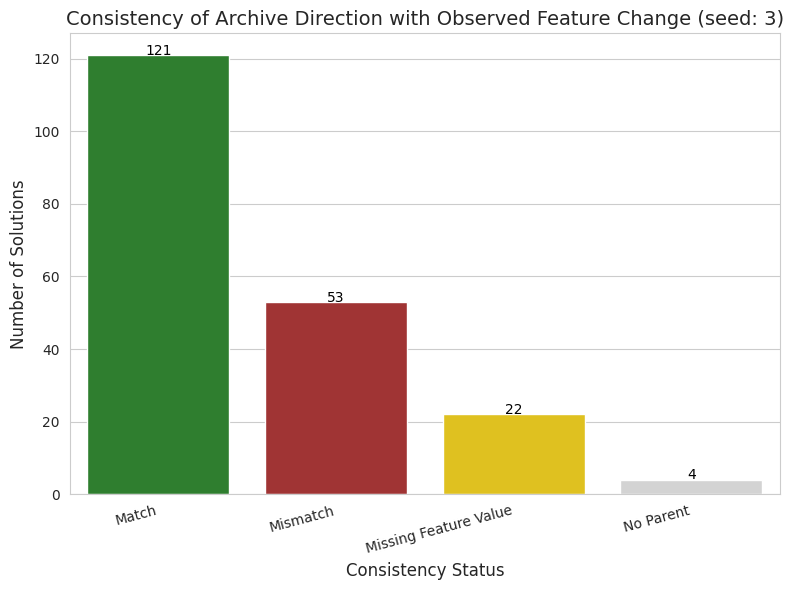

,Consistency Status,Count
0,Mismatch,95
1,Match,60
2,Missing Feature Value,41
3,No Parent,4
4,Match,94
5,Mismatch,69
6,Missing Feature Value,33
7,No Parent,4
8,Mismatch,119
9,Match,57


In [18]:
# The next thing is that I want to see how often the "archive_feature" given the "archive_direction" changed from parent to child solution. 

def analyze_archive_direction_consistency(df, name="ES-guided"):
    """
    Analyzes the consistency between the observed feature value change 
    (parent to child) and the recorded 'archive_direction', and visualizes it.

    Args:
        df (pd.DataFrame): DataFrame with 'id', 'parent_ids', 'ast_features',
        'archive_feature', and 'archive_direction'.

    Returns:
        pd.DataFrame: DataFrame containing the Match/Mismatch counts.
    """
    # 1. Index the DataFrame by 'id' for fast lookups
    df_indexed = df.set_index('id')

    def normalize_key(key):
        """
        Converts any feature key (e.g., 'Mean_Complexity', 'Max Degree') 
        to a standardized format (e.g., 'mean complexity') for robust lookup.
        """
        key = str(key).lower()
        # Replace underscores with spaces (handles snake_case keys like mean_complexity)
        key = key.replace('_', ' ')
        # Collapse multiple spaces and strip leading/trailing spaces
        return ' '.join(key.split()).strip()
    

    def get_feature_value(ast_features_dict, target_feature):
        """Looks up the value in the AST features using the normalized key."""
        # Normalize the target feature name (from archive_feature column)
        normalized_target = normalize_key(target_feature)
        
        # Create a new dictionary with ALL keys normalized for efficient lookup
        normalized_dict = {normalize_key(k): v for k, v in ast_features_dict.items()}
        
        # Look up the value
        return normalized_dict.get(normalized_target)

    def check_direction_consistency(row):
        """
        Compares the observed change in feature value (parent -> child) 
        with the recorded 'archive_direction'.
        """
        parent_ids = row['parent_ids']
        archive_feature = row['archive_feature']
        archive_direction = row['archive_direction']

        # Skip rows without a parent
        if not parent_ids:
            return 'No Parent'

        # Assume only one parent ID in the list
        parent_id = parent_ids[0]

        try:
            # 2. Lookup Parent Row and Feature Value
            parent_row = df_indexed.loc[parent_id]
            
            # Get feature values using the robust lookup function
            v_parent = get_feature_value(parent_row['ast_features'], archive_feature)
            v_child = get_feature_value(row['ast_features'], archive_feature)

            # Handle cases where feature values are missing
            if v_parent is None or v_child is None:
                return 'Missing Feature Value'

            # 3. Determine Observed Direction
            if v_child > v_parent:
                observed_direction = 'increase'
            elif v_child < v_parent:
                observed_direction = 'decrease'
            else:
                observed_direction = 'no change'

            # 4. Check for Match
            # 'no change' is considered a mismatch for 'increase'/'decrease' targets
            if observed_direction == archive_direction:
                return 'Match'
            else:
                # If 'no change' occurred, we classify it as Mismatch against the target direction
                return 'Mismatch'

        except KeyError:
            # Handle case where parent ID is not found in the DataFrame
            return 'Parent Not Found'
        except Exception:
            # Catch other potential errors
            return 'Error in Calculation'

    # Apply the check to every row
    df['consistency'] = df.apply(check_direction_consistency, axis=1)

    # Get all unique seeds
    unique_seeds = df['seed'].unique()

    # Set up plotting style
    sns.set_style("whitegrid")

    all_consistency_counts = pd.DataFrame()

    for seed in unique_seeds:
        # Filter data for the current seed
        df_seed = df[df['seed'] == seed]

        # 5. Count the matches, mismatches, and other categories
        consistency_counts = df_seed['consistency'].value_counts().reset_index()
        consistency_counts.columns = ['Consistency Status', 'Count']
        
        # 6. Visualization (Bar Chart)
        plt.figure(figsize=(8, 6))
        
        # Define a clear color palette
        color_map = {'Match': 'forestgreen', 'Mismatch': 'firebrick', 'No Parent': 'lightgray', 
                    'Parent Not Found': 'orange', 'Missing Feature Value': 'gold', 'Error in Calculation': 'black'}
        
        # Ensure the colors are only applied to the statuses that are present in the counts
        plot_colors = [color_map.get(status, 'gray') for status in consistency_counts['Consistency Status']]
        
        sns.barplot(
            data=consistency_counts,
            x='Consistency Status',
            y='Count',
            hue='Consistency Status',
            legend=False,
            palette=plot_colors,
            order=consistency_counts['Consistency Status']
        )
        
        plt.title(f'Consistency of Archive Direction with Observed Feature Change (seed: {seed})', fontsize=14)
        plt.xlabel('Consistency Status', fontsize=12)
        plt.ylabel('Number of Solutions', fontsize=12)
        plt.xticks(rotation=15, ha='right')
        
        # Add counts on top of bars
        for index, row in consistency_counts.iterrows():
            plt.text(index, row['Count'] + 0.05, str(row['Count']), color='black', ha="center")

        plt.tight_layout()
        file_name = f'archive_direction_consistency_histogram_{name}_{seed}.png'
        plt.savefig(file_name)
        plt.show()
        plt.close()

        all_consistency_counts = pd.concat([all_consistency_counts, consistency_counts], ignore_index=True)

    return all_consistency_counts

all_consistency_counts = analyze_archive_direction_consistency(data[data['method_name'] == "ES-guided"], "ES-guided-global")
#all_consistency_counts = analyze_archive_direction_consistency(data[data['method_name'] == "ES-guided-new"], "ES-guided-local")
all_consistency_counts

In [ ]:
plot_experiment_CEG(logger, save=False, budget=200, max_seeds=5, metric="max_degree")

/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/home/neocortex/repos/BLADE/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: divide by zero encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
